<a href="https://colab.research.google.com/github/antonsysoev/comp_tech_2024/blob/main/Lecture_11_Clustering_Game_of_Thrones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1 Предисловие

Серия романов под названием "Песнь Льда и Пламени"  насыщена персонажами и имеет очень плотную паутину событий. Поэтому фанаты могут создавать свои собственные теории и подкреплять их доказательствами из текста. Также автор саги Г.Р.Р. Мартин как-то сказал, что у него в голове был целый сюжет еще до первой строчки романа. Сочинение добавляет к сюжету только детали.

Это дает нам возможность предположить, что в романе существует жесткая структура. Давайте посмотрим, позволяют ли некоторые известные данные данного персонажа узнать, в какой команде он играет в этой жестокой игре.

In [ ]:
install.packages("dplyr")
install.packages("Hmisc")
install.packages("corrplot")
install.packages("scales")
install.packages("fpc")
install.packages("reshape2")
install.packages("ggplot2")
install.packages("NbClust")
install.packages("mclust")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘Formula’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘modeltools’, ‘DEoptimR’, ‘mclust’, ‘flexmix’, ‘prabclus’, ‘diptest’, ‘robustbase’, ‘kernlab’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is uns

In [ ]:
library(dplyr)
library(Hmisc)
library(corrplot)
library(scales)
library(fpc)
library(reshape2)
library(ggplot2)
library(NbClust)
library(mclust)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


corrplot 0.95 loaded

Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



2 Получение и очистка данных

Прежде всего мы подключаем некоторые библиотеки и считываем данные. Затем мы объединяем два набора данных о персонажах, используя только тех, кто есть в обоих наборах. Этот шаг уменьшает количество наблюдений в конечном наборе данных, но дает нам больше характеристик для каждого наблюдения. Затем мы нормализуем все числа и помечаем каждое наблюдение альянсами.

Наконец, мы удаляем слово "House" из столбца Allegiances, чтобы избежать пар типа "House Baratheon" и "Baratheon".


In [ ]:
char <- read.csv("character-deaths.csv", stringsAsFactors = F)
char.pred <- read.csv("character-predictions.csv", stringsAsFactors = F)

names(char.pred)[which(names(char.pred) == "name")] <- "Name"

some.of.them <- inner_join(char, char.pred, by = "Name")
some.of.them$age[187] <- 20 #Correction of obvious outlier
numb <- some.of.them[, which(sapply(some.of.them,class) != "character")]
numb[is.na(numb)] <- -100
numb <- as.data.frame(scale(numb))
numb <- cbind("Allegiances" = some.of.them$Allegiances, numb)
numb$Allegiances <- gsub("House ", "", numb$Allegiances)

3 Корреляция столбцов

Поскольку мы объединяем два независимых набора, созданных из одного источника, возможны корреляции столбцов. Давайте проверим.

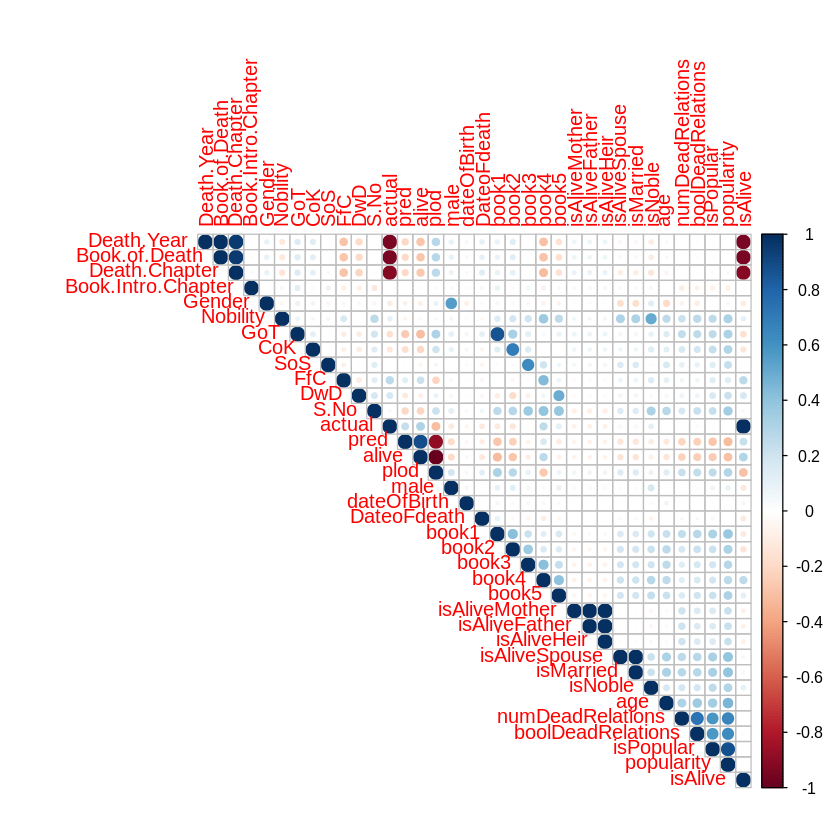

In [ ]:
M <- rcorr(as.matrix(numb[,-1]))
corrplot(M$r, type="upper")

Яркие круги указывают на наличие корреляции. Давайте рассмотрим их подробнее. Для этого удобнее использовать таблицу. Берем только пары с корреляцией более 0,5.

In [ ]:
tri <- upper.tri(M$r)
corr.values <- data.frame(row = rownames(M$r)[row(M$r)[tri]],
                          column = rownames(M$r)[col(M$r)[tri]],
                          cor  =(M$r)[tri])
corr.values[which(abs(corr.values$cor) > 0.5),]

,row,column,cor
,<chr>,<chr>,<dbl>
1,Death.Year,Book.of.Death,0.9944641
2,Death.Year,Death.Chapter,0.9516283
3,Book.of.Death,Death.Chapter,0.9550174
67,Death.Year,actual,-0.9405137
68,Book.of.Death,actual,-0.9408104
69,Death.Chapter,actual,-0.9113445
105,pred,alive,0.8821471
119,pred,plod,-0.8821471
120,alive,plod,-1.0000000


Пары выглядят странно. "isAliveMother" и "isAliveFather" коррелируют с коэффициентом 1. Значит, сиротство в серии неизбежно. Nobility и isNoble коррелируют всего с 0,5, но это нормально, из-за более сложного подхода в одном из наборов. Но почему "Пол" и "мужчина" имеют такой маленький коэффициент? Давайте посмотрим внимательнее.

In [ ]:
head(some.of.them[which(some.of.them$Gender != some.of.them$male),
             c("Name", "male", "Gender")], 15)

,Name,male,Gender
,<chr>,<int>,<int>
4,Aenys Frey,1,0
6,Aethan,0,1
8,Aggo,0,1
14,Alesander Staedmon,0,1
22,Alyn Stackspear,0,1
25,Alyx Frey,0,1
26,Ambrode,0,1
30,Andrey Dalt,0,1
47,Arwyn Oakheart,1,0


Поскольку "1" означает "мужчина" в обоих наборах, столбец "Пол" выглядит более корректно. Давайте удалим "male" и все остальные коррелирующие столбцы.

In [ ]:
to.remove <- c("Death.Year", "Book.of.Death", "Death.Chapter", "pred", "plod",
               "male", "book1", "book2", "book3", "isAliveMother",
               "isAliveHeir", "isAliveSpouse", "isNoble", "dateOfBirth",
               "numDeadRelations", "boolDeadRelations", "isPopular", "isAlive")
numb <- numb[, -which(names(numb) %in% to.remove)]

**4 Кластерный анализ**

**4.1 Выбор количества кластеров **

Важность выбора количества кластеров трудно переоценить. В идеальном мире могло бы быть 12 кластеров, по одному на каждый дом. А еще лучше - 4 кластера в соответствии с командами. То есть "Ланнистеры", "Старки", "Против всех" и "Нейтралы". Давайте добавим колонку "Команда" в наш набор данных.

In [ ]:
Lannister.team <- c("Lannister", "Tyrell")
Stark.team <- c("Arryn", "Baratheon", "Stark", "Tully")
Against.all.team <- c("Martell", "Greyjoy", "Targaryen", "Wildling")
Neutral.team <- c("Night's Watch", "None")
numb$Team <- ifelse(numb$Allegiances %in% Lannister.team, numb$Team <- "Lannister team",
                    ifelse(numb$Allegiances %in% Stark.team, numb$Team <- "Stark team",
                           ifelse(numb$Allegiances %in% Against.all.team,
                                  numb$Team <- "Against all", "Neutral")))
table(numb$Team)


   Against all Lannister team        Neutral     Stark team 
           174            121            331            224 

Похоже, что у Старков больше союзников, чем у Ланнистеров, а большинство персонажей - нейтральны.

Попробуем найти количество кластеров с помощью библиотеки NbClust.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


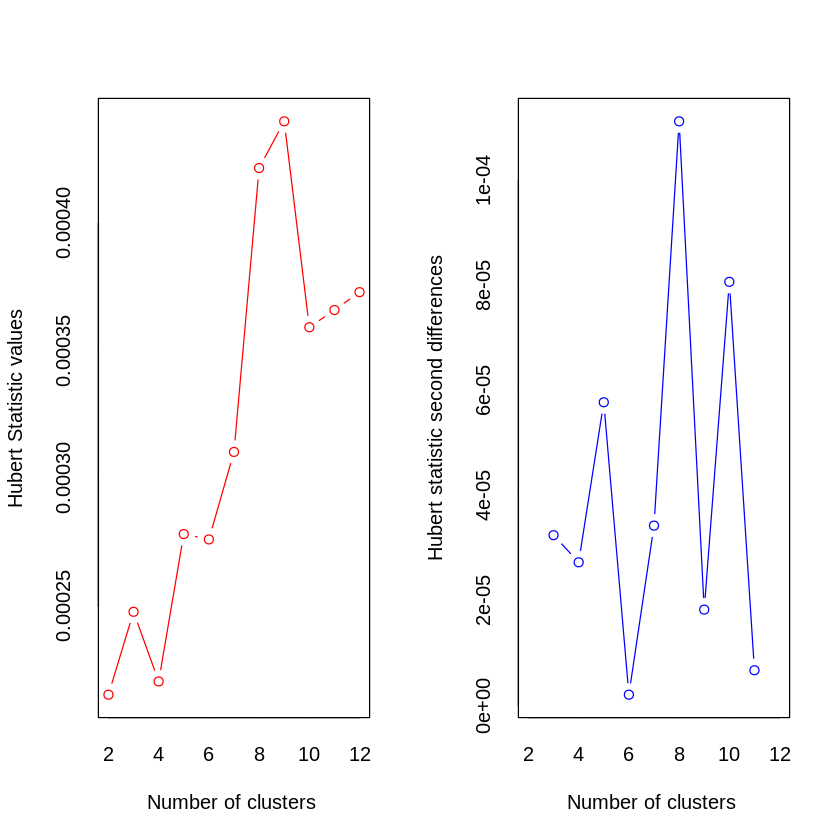

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 6 proposed 2 as the best number of clusters 
* 5 proposed 3 as the best number of clusters 
* 2 proposed 4 as the best number of clusters 
* 1 proposed 8 as the best number of clusters 
* 5 proposed 9 as the best number of clusters 
* 3 proposed 10 as the best number of clusters 
* 1 proposed 11 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  2 
 
 
******************************************************************* 


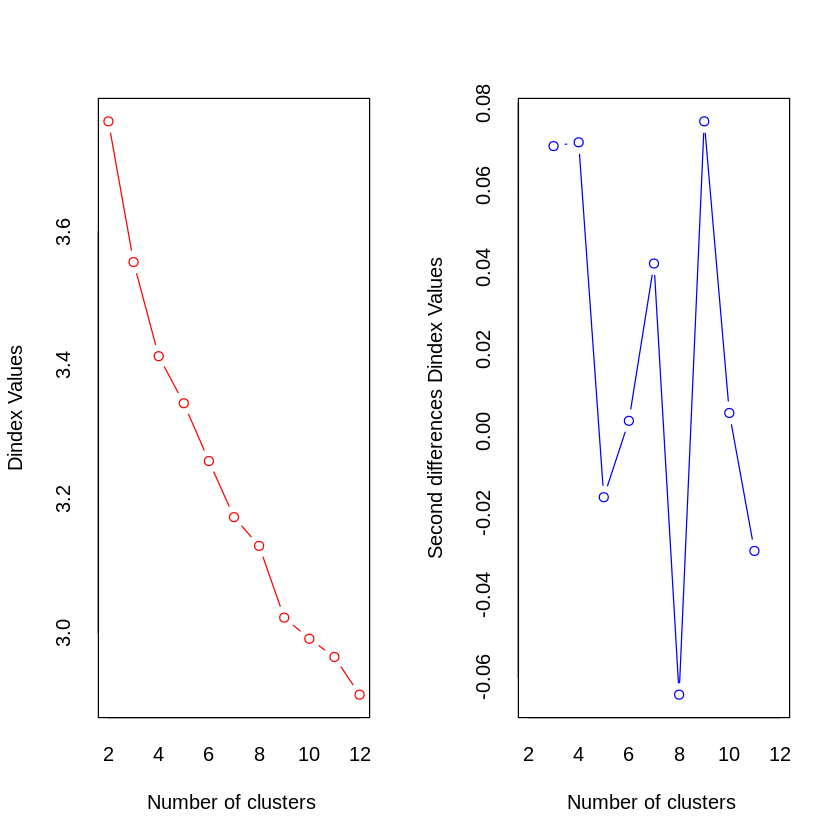

In [ ]:
res <- NbClust(numb[,-c(1,20)], distance = "euclidean",
               min.nc=2, max.nc=12, method = "kmeans")

Похоже, что наилучшее количество кластеров - 2. Четыре даже не входят в число номинантов. Хорошо, давайте попробуем другую библиотеку, которая называется mclust.

In [ ]:
res <- Mclust(numb[,-c(1,20)])
summary(res)

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust EEE (ellipsoidal, equal volume, shape and orientation) model with 7
components: 

 log-likelihood   n  df       BIC       ICL
      -12511.43 850 303 -27066.66 -27080.88

Clustering table:
  1   2   3   4   5   6   7 
120  89 197 169 132 137   6 

**4.2 Кластеризация по методу К-средних**

,Against all,Lannister team,Neutral,Stark team
,<int>,<int>,<int>,<int>
1,113,93,184,151
2,61,28,147,73


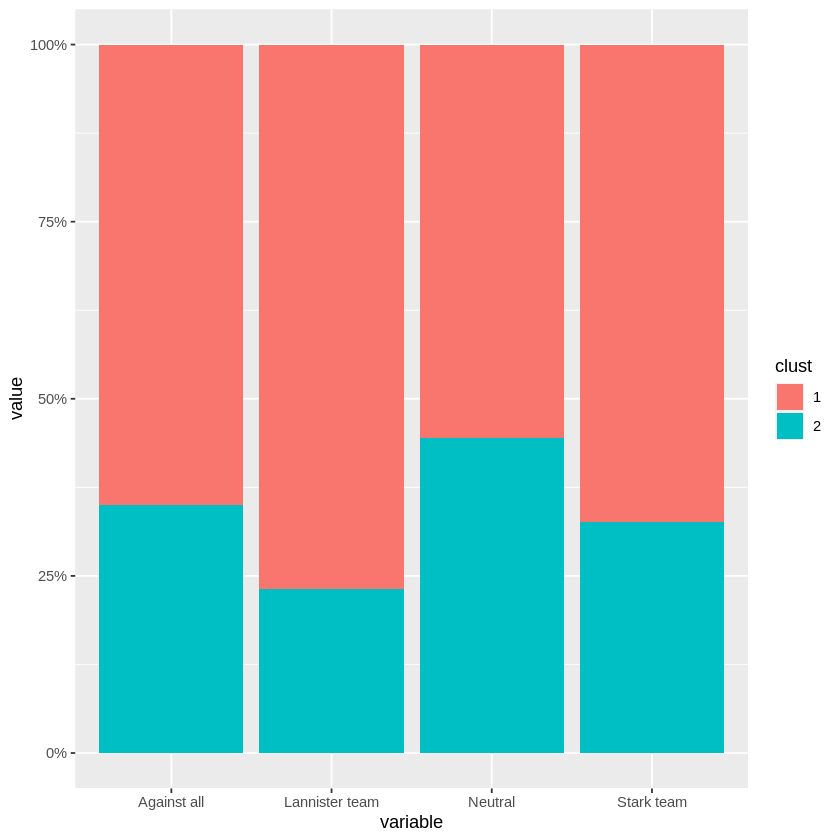

,Against all,Lannister team,Neutral,Stark team
,<int>,<int>,<int>,<int>
1,18,29,26,26
2,80,35,115,52
3,48,20,126,63
4,28,37,64,83


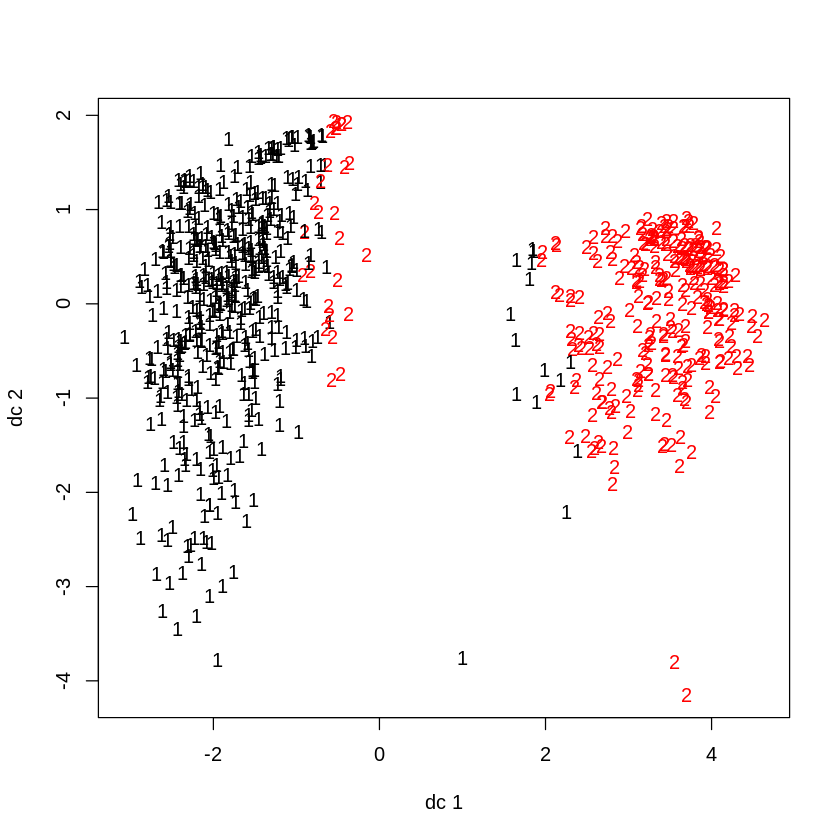

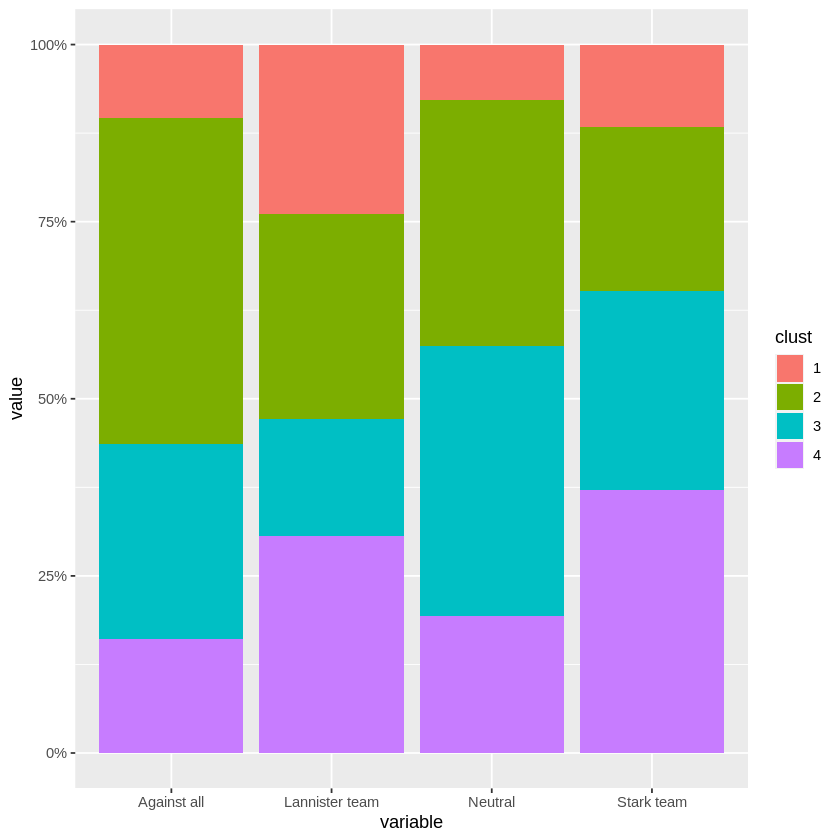

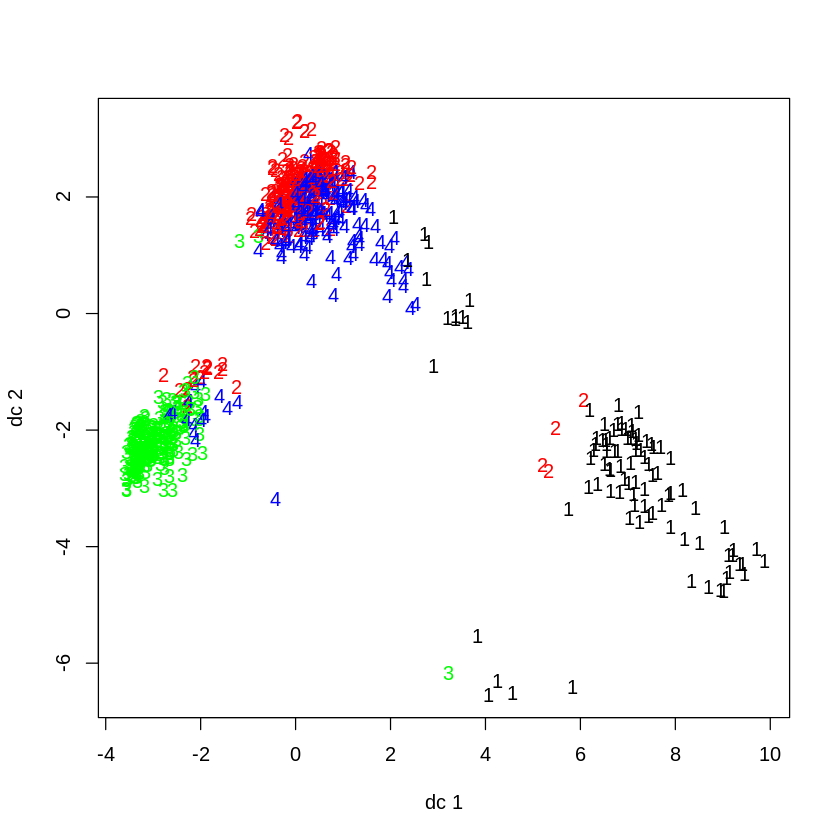

In [ ]:
plot.team <- function(data){
    dat.clust <- melt(cbind(data, clust = rownames(data)), id.vars = c('clust'))
    ggplot(dat.clust, aes(x = variable, y = value, fill = clust)) +
        geom_bar(position = "fill", stat = "identity") +
        scale_y_continuous(labels = percent_format())
}

fit.2 <- kmeans(numb[,-c(1,20)], 2)
dat.2 <- as.data.frame.matrix(table(fit.2$cluster, numb$Team))
dat.2
plot.team(dat.2)
plotcluster(numb[,-c(1,20)], fit.2$cluster)

fit.4 <- kmeans(numb[,-c(1,20)], 4)
dat.4 <- as.data.frame.matrix(table(fit.4$cluster, numb$Team))
dat.4
plot.team(dat.4)
plotcluster(numb[,-c(1,20)], fit.4$cluster)

Как видим, ни два, ни четыре кластера не соответствуют командам Game of Throne. Значит ли это, что у сюжета этого нет структуры? Или это значит, что литература, как и сама жизнь, не поддается расчету?